In [ ]:
# IMPORTANT: PackageMap XML Error Fix
# If you're getting "XML_ERROR_FILE_NOT_FOUND" errors, you're likely using a .venv
# In Docker with the manipulation image, it's better to use the system Python
# which has manipulation pre-installed correctly.

# Option 1: Use system Python (recommended for Docker)
# Just select the system Python kernel, not the .venv kernel

# Option 2: If you must use .venv, ensure manipulation is installed with --no-deps
# and the package resources are accessible. This is complex and not recommended.

print("For Docker: Use the system Python kernel, not .venv")
print("The manipulation Docker image already has everything installed correctly.")


: 

# Catching a Falling Object

In this notebook, we will learn how to catch an object that is falling with a Kuka iiwa-7. This task is difficult because of the timing components. You will be responsible for calculating the rate at which an object is falling using several Intel Realsense cameras and then calculating the expected position of the object at a certain point in time, where you will catch the object.


**Learning Objectives:**
1. Implement a system that is able to accurately prediction the falling location of a system above.
2. Implement control (probably force control) to catch a falling object without it hitting the ground.

**What you'll build:** A complete system with Kuka and Realsense cameras that is able to estimate the falling position of an object and catch the object.

---


## Project Template (Deepnote)

You can use this notebook as a starting point for your class project and/or the extra exercise for graduate students in Deepnote. It comes set up with the dependencies we use in class, so you don't have to install these yourself.

**Notes:**
- To use this in your own workspace, click “Duplicate” for the project in Deepnote.
- Class dependencies, namely `drake` and the `manipulation` package, are already preinstalled in the Deepnote image for this course, as well as a bunch of other dependencies that these packages depend on or that we use in class
- To see the full list of installed dependencies, as well as version numbers etc, see this file: [pyproject.toml](https://github.com/RussTedrake/manipulation/blob/master/pyproject.toml).
  - **Note**: we install all the extra dependencies, including the `dev` dependencies, into the Docker image that this deepnote project runs on.


### (Advanced Users) Installing additional dependencies

Here we show you how to install additional packages into this Deepnote project. We will use the package [gcsopt](https://pypi.org/project/gcsopt/) as an example. To install additional dependencies, you have two choices:
- **Recommended** (automatically installs your dependencies every time you boot the Deepnote machine):
  1. Add the dependency to the list of dependencies in `reqirements.txt` on the left.  
      - **Note**: Make sure to NOT remove the text that is already in the file. You should add your dependencies on new lines AFTER `manipulation=year.month.day`. For our example, the file contents will look like:
          ```
          --extra-index-url https://drake-packages.csail.mit.edu/whl/nightly
          manipulation==2025.9.23
          gcsopt
          ```
  2. Restart the Deepnote machine (or run the `Init` notebook)
- **Alternatively:** Run `!pip install gcsopt` within a cell in the Deepnote notebook. You will have to do this everytime you restart your Deepnote machine.

### (Advanced Users) Updating the `manipulation` version
We continually add new features to the `manipulation` package, which is automatically updated in Deepnote. However, after you first click "Duplicate", you will stop receiving these updates. Follow these steps to update your version to the latest version:
1. Find the latest version number for `manipulation` on the [PyPi package page](https://pypi.org/project/manipulation/#history).
2. Update the version number for `manipulation=year.month.day` in the `requirements.txt` file on the left
3. Restart the Deepnote machine (or run the `Init` notebook)

The changes will persist every time you start your Deepnote machine.

Good luck!

---


## Placeholder code: iiwa Simulation

As a starting point, the code below sets up a simple simulation with a single iiwa, visualized in Meshcat.

### Setup and imports
Let us first get our imports out of the way:

In [ ]:
# Step 1: Setup and imports
import os
import time
from pathlib import Path
from textwrap import dedent

import numpy as np
from pydrake.all import (
    BasicVector,
    Context,
    DiagramBuilder,
    Integrator,
    InverseKinematics,
    LeafSystem,
    MultibodyPlant,
    PiecewisePolynomial,
    RigidTransform,
    RotationMatrix,
    Simulator,
    Solve,
    StartMeshcat,
    TrajectorySource,
)

from manipulation import running_as_notebook
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.station import LoadScenario, MakeHardwareStation


/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Meshcat Visualization

As always, let's start Meshcat for our 3D visualization!

In [12]:
# Start meshcat for visualization
meshcat = StartMeshcat()
print("Click the link above to open Meshcat in your browser!")

INFO:drake:Meshcat listening for connections at http://localhost:7000


Click the link above to open Meshcat in your browser!


In [ ]:
# Step 2: Set up directories
outdir = "scenarios"
assets_dir = "assets"
os.makedirs(outdir, exist_ok=True)
os.makedirs(assets_dir, exist_ok=True)

In [ ]:
# Step 3: We'll use sugar_box from the manipulation package instead of creating a letter
# The sugar_box is already available in the package, so we don't need to create it

PosixPath('assets/A_big_model/A.sdf')

In [ ]:
# Step 4: Create scenario with variable starting position for falling object
# Default starting position: [x, y, z] with z = 5m
object_start_position = [0.5, 0.0, 5.0]  # [x, y, z] in meters - can be changed

# Catch height (height above ground where we want to catch)
catch_height = 0.5  # meters above ground

# Sugar box dimensions (approximate - will get actual from model)
# Sugar box is roughly 0.2m x 0.1m x 0.05m (length x width x height)
box_thickness = 0.05  # thickness in z direction (height)
gripper_opening = box_thickness + 0.1  # gripper opening = box_thickness + 0.1

scenario_yaml = f"""
directives:
- add_model:
    name: iiwa
    file: package://drake_models/iiwa_description/sdf/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0

- add_model:
    name: wsg
    file: package://manipulation/hydro/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy {{ deg: [90, 0, 90]}}

- add_model:
    name: table
    file: package://manipulation/table.sdf
- add_weld:
    parent: world
    child: table::table_link
    X_PC:
        translation: [0.0, 0.0, -0.05]
        rotation: !Rpy {{ deg: [0, 0, -90] }}

# Sugar box placed in the scene (free body pose - will fall)
- add_model:
    name: sugar_box
    file: package://manipulation/hydro/004_sugar_box.sdf
    default_free_body_pose:
        base_link_sugar:
            translation: [{object_start_position[0]}, {object_start_position[1]}, {object_start_position[2]}]
            rotation: !Rpy {{ deg: [0, 0, 0] }}

model_drivers:
    iiwa: !IiwaDriver
      control_mode: position_only
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {{}}
"""

# Write scenario file
scenario_file = os.path.join(outdir, "catching_scenario.yaml")
with open(scenario_file, "w") as f:
    f.write(dedent(scenario_yaml).lstrip())

print(f"Scenario created with object starting at: {object_start_position}")
print(f"Catch height: {catch_height}m")
print(f"Gripper opening: {gripper_opening}m")

In [ ]:
class ManipulationStationSim:
    def __init__(
        self,
        scenario_file: str | None = None,
        q_iiwa: tuple | None = None,
        gripper_setpoint: float = 0.1,
    ) -> None:

        self.scenario = None
        self.station = None
        self.plant = None
        self.scene_graph = None
        self.query_output_port = None
        self.diagram = None

        # contexts
        self.context_diagram = None
        self.context_station = None
        self.context_scene_graph = None
        self.context_plant = None

        # mark initial configuration
        self.q0 = None

        self.okay_collisions = None
        self.gripper_setpoint = gripper_setpoint

        if scenario_file is not None:
            self.choose_sim(scenario_file, q_iiwa, gripper_setpoint)

    def choose_sim(
        self,
        scenario_file: str,
        q_iiwa: tuple | None = None,
        gripper_setpoint: float = 0.1,
    ) -> None:

        self.clear_meshcat()

        self.scenario = LoadScenario(filename=scenario_file)
        builder = DiagramBuilder()
        self.station = builder.AddSystem(
            MakeHardwareStation(self.scenario, meshcat=meshcat)
        )

        self.plant = self.station.GetSubsystemByName("plant")

        self.scene_graph = self.station.GetSubsystemByName("scene_graph")

        # scene graph query output port.
        self.query_output_port = self.scene_graph.GetOutputPort("query")

        self.diagram = builder.Build()

        # contexts
        self.context_diagram = self.diagram.CreateDefaultContext()
        self.context_station = self.diagram.GetSubsystemContext(
            self.station, self.context_diagram
        )
        self.station.GetInputPort("iiwa.position").FixValue(
            self.context_station, np.zeros(7)
        )
        self.station.GetInputPort("wsg.position").FixValue(self.context_station, [0.1])
        self.context_scene_graph = self.station.GetSubsystemContext(
            self.scene_graph, self.context_station
        )
        self.context_plant = self.station.GetMutableSubsystemContext(
            self.plant, self.context_station
        )

        # mark initial configuration
        self.gripper_setpoint = gripper_setpoint
        if q_iiwa is None:
            self.q0 = self.plant.GetPositions(
                self.context_plant, self.plant.GetModelInstanceByName("iiwa")
            )
        else:
            self.q0 = q_iiwa
            self.SetStationConfiguration(q_iiwa, gripper_setpoint)

        self.DrawStation(self.q0, 0.1)
        query_object = self.query_output_port.Eval(self.context_scene_graph)
        self.okay_collisions = len(query_object.ComputePointPairPenetration())

    def clear_meshcat(self) -> None:
        meshcat.Delete()

    def SetStationConfiguration(self, q_iiwa: tuple, gripper_setpoint: float) -> None:
        """
        :param q_iiwa: (7,) tuple, joint angle of robots in radian.
        :param gripper_setpoint: float, gripper opening distance in meters.
        :return:
        """
        self.plant.SetPositions(
            self.context_plant,
            self.plant.GetModelInstanceByName("iiwa"),
            q_iiwa,
        )
        self.plant.SetPositions(
            self.context_plant,
            self.plant.GetModelInstanceByName("wsg"),
            [-gripper_setpoint / 2, gripper_setpoint / 2],
        )

    def DrawStation(self, q_iiwa: tuple, gripper_setpoint: float = 0.1) -> None:
        self.SetStationConfiguration(q_iiwa, gripper_setpoint)
        self.diagram.ForcedPublish(self.context_diagram)

    def ExistsCollision(self, q_iiwa: tuple, gripper_setpoint: float) -> bool:
        """
        Checks for an unwanted collision for a given robot configuration
        (q_iiwa) and gripper setpoint (gripper_setpoint)

        Args:
            q_iiwa: given robot configuration
            gripper_setpoint: gripper width
        Returns:
            bool: True if an unwnted collision exists, False otherwise
        """

        self.SetStationConfiguration(q_iiwa, gripper_setpoint)
        query_object = self.query_output_port.Eval(self.context_scene_graph)
        collision_pairs = query_object.ComputePointPairPenetration()

        return len(collision_pairs) > self.okay_collisions

In [ ]:
# Step 6: Load scenario and get object information
scenario = LoadScenario(filename=scenario_file)
station = MakeHardwareStation(scenario, meshcat=meshcat)
plant = station.GetSubsystemByName("plant")
scene_graph = station.GetSubsystemByName("scene_graph")

# Get model instances
iiwa_instance = plant.GetModelInstanceByName("iiwa")
sugar_box_instance = plant.GetModelInstanceByName("sugar_box")

# Get initial configuration
context = station.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
q0 = plant.GetPositions(plant_context, iiwa_instance)

# Get initial pose of sugar box
sugar_box_body = plant.GetBodyByName("base_link_sugar", sugar_box_instance)
X_WO_initial = plant.EvalBodyPoseInWorld(plant_context, sugar_box_body)

print(f"Initial robot configuration: {q0}")
print(f"Initial object position: {X_WO_initial.translation()}")

In [ ]:
# Step 7: IK-based Controller for Catching
# This controller uses IK to plan waypoints along the predicted trajectory

def solve_ik_for_pose(plant, X_WG_target, q_nominal, plant_context):
    """Solve IK for a target gripper pose"""
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName("body")

    ik = InverseKinematics(plant, plant_context)
    q_vars = ik.q()[:7]  # Only iiwa joints
    prog = ik.prog()

    # Add position constraint
    ik.AddPositionConstraint(
        frameB=gripper_frame,
        p_BQ=[0, 0.1, 0],  # Gripping point offset
        frameA=world_frame,
        p_AQ_lower=X_WG_target.translation(),
        p_AQ_upper=X_WG_target.translation(),
    )

    # Add orientation constraint (gripper should be horizontal to catch from bottom)
    # We want the gripper to approach from below, so z-axis should point up
    R_WG_des = X_WG_target.rotation()
    ik.AddOrientationConstraint(
        frameAbar=world_frame,
        R_AbarA=R_WG_des,
        frameBbar=gripper_frame,
        theta_bound=0.1,
    )

    # Joint centering cost
    prog.AddQuadraticErrorCost(
        np.eye(7), q_nominal, q_vars
    )

    # Set initial guess
    prog.SetInitialGuess(q_vars, q_nominal)

    result = Solve(prog)
    if not result.is_success():
        return None

    return result.GetSolution(q_vars)

class CatchingController(LeafSystem):
    """Controller that plans trajectory to catch falling object"""

    def __init__(self, plant, iiwa_instance, sugar_box_instance,
                 catch_height, gripper_opening, box_thickness):
        LeafSystem.__init__(self)
        self._plant = plant
        self._iiwa_instance = iiwa_instance
        self._sugar_box_instance = sugar_box_instance
        self._catch_height = catch_height
        self._gripper_opening = gripper_opening
        self._box_thickness = box_thickness

        # Input: current object state [x, y, z, vx, vy, vz]
        self.DeclareVectorInputPort("object_state", 6)

        # Input: current robot joint positions
        self.DeclareVectorInputPort("iiwa.position", 7)

        # Output: desired joint positions
        self.DeclareVectorOutputPort("iiwa.position_command", 7,
                                     self.CalcPositionCommand)

        # Output: gripper command (opening distance)
        self.DeclareVectorOutputPort("wsg.position", 1, self.CalcGripperCommand)

        # Output: gripper force (for force control)
        self.DeclareVectorOutputPort("wsg.force_limit", 1, self.CalcGripperForce)

        self._plant_context = plant.CreateDefaultContext()
        self._gripper_closed = False
        self._last_catch_time = -1.0

    def CalcPositionCommand(self, context, output):
        """Calculate desired joint positions to catch the object"""
        object_state = self.get_input_port(0).Eval(context)
        q_current = self.get_input_port(1).Eval(context)
        t = context.get_time()

        # Update plant context
        self._plant.SetPositions(self._plant_context, self._iiwa_instance, q_current)

        # Get current object position and velocity
        x, y, z = object_state[0], object_state[1], object_state[2]
        vx, vy, vz = object_state[3], object_state[4], object_state[5]

        # Predict where object will be at catch height
        # Solve: catch_height = z + vz*t - 0.5*g*t^2
        g = 9.81
        a = 0.5 * g
        b = -vz
        c = -(z - self._catch_height)

        discriminant = b**2 - 4*a*c
        if discriminant < 0:
            # Object won't reach catch height, move to current position
            target_pos = np.array([x, y, self._catch_height])
        else:
            t_catch = (-b + np.sqrt(discriminant)) / (2*a)
            if t_catch < 0:
                t_catch = (-b - np.sqrt(discriminant)) / (2*a)

            # Predict position at catch time
            x_catch = x + vx * t_catch
            y_catch = y + vy * t_catch
            target_pos = np.array([x_catch, y_catch, self._catch_height])

        # Design grasp pose: approach from below
        # Gripper should be at catch_height - small offset to catch from bottom
        grasp_z = self._catch_height - 0.02  # Slightly below catch height

        # Orientation: gripper horizontal, z-axis up (to catch from bottom)
        R_WG = RotationMatrix.MakeZRotation(np.pi/2)  # Rotate to catch horizontally
        X_WG_target = RigidTransform(R_WG, [target_pos[0], target_pos[1], grasp_z])

        # Solve IK
        q_desired = solve_ik_for_pose(
            self._plant, X_WG_target, q_current, self._plant_context
        )

        if q_desired is None:
            # IK failed, return current position
            output.SetFromVector(q_current)
        else:
            output.SetFromVector(q_desired)

    def CalcGripperCommand(self, context, output):
        """Calculate gripper opening command"""
        object_state = self.get_input_port(0).Eval(context)
        t = context.get_time()

        z = object_state[2]
        vz = object_state[5]

        # Check if bottom of box has passed catch height
        # Bottom of box is at z - box_thickness/2
        box_bottom = z - self._box_thickness / 2

        if box_bottom <= self._catch_height and not self._gripper_closed:
            # Close gripper when bottom passes catch height
            self._gripper_closed = True
            self._last_catch_time = t

        if self._gripper_closed:
            # Close gripper (small opening to grip)
            output.SetFromVector([0.01])  # Almost closed
        else:
            # Open gripper
            output.SetFromVector([self._gripper_opening])

    def CalcGripperForce(self, context, output):
        """Calculate gripper force limit for force control"""
        if self._gripper_closed:
            # Apply force to hold object (40N is reasonable)
            output.SetFromVector([40.0])
        else:
            # No force when open
            output.SetFromVector([0.0])


In [ ]:
# Step 8: Build complete simulation diagram with controller

builder = DiagramBuilder()

# Add station
station_sys = builder.AddSystem(station)

# Create trajectory predictor
trajectory_predictor = builder.AddSystem(TrajectoryPredictor(g=9.81))

# Create catching controller
controller = builder.AddSystem(CatchingController(
    plant, iiwa_instance, sugar_box_instance,
    catch_height, gripper_opening, box_thickness
))

# Create integrator for velocity to position (if needed)
# For now, we'll use position commands directly

# Connect object state to trajectory predictor
# We need to get object state from the plant
# For now, we'll create a system that extracts object state

class ObjectStateExtractor(LeafSystem):
    """Extracts object position and velocity from plant"""
    def __init__(self, plant, sugar_box_instance):
        LeafSystem.__init__(self)
        self._plant = plant
        self._sugar_box_instance = sugar_box_instance
        self._sugar_box_body = plant.GetBodyByName("base_link_sugar", sugar_box_instance)

        # Input: plant state (we'll get this from station)
        # Actually, we'll need to get this differently - from station's body_poses output
        # For now, let's use a different approach

    def get_object_state(self, plant_context):
        """Get current object state"""
        # Get pose
        X_WO = self._plant.EvalBodyPoseInWorld(plant_context, self._sugar_box_body)
        pos = X_WO.translation()

        # Get velocity (spatial velocity)
        V_WO = self._plant.EvalBodySpatialVelocityInWorld(plant_context, self._sugar_box_body)
        vel = V_WO.translational()

        return np.concatenate([pos, vel])

# For simplicity, let's use a periodic update system
# We'll connect the controller directly and update it periodically

# Connect controller outputs to station inputs
builder.Connect(
    controller.get_output_port("iiwa.position_command"),
    station_sys.GetInputPort("iiwa.position")
)

builder.Connect(
    controller.get_output_port("wsg.position"),
    station_sys.GetInputPort("wsg.position")
)

builder.Connect(
    controller.get_output_port("wsg.force_limit"),
    station_sys.GetInputPort("wsg.force_limit")
)

# Connect station outputs to controller inputs
builder.Connect(
    station_sys.GetOutputPort("iiwa.position_measured"),
    controller.get_input_port("iiwa.position")
)

# For object state, we'll need to create a system that reads from plant
# Let's create a simpler approach: update controller with plant context

class ObjectStateProvider(LeafSystem):
    """Provides object state by reading from plant body_poses output"""
    def __init__(self, plant, sugar_box_instance, sugar_box_body):
        LeafSystem.__init__(self)
        self._plant = plant
        self._sugar_box_instance = sugar_box_instance
        self._sugar_box_body = sugar_box_body
        self._body_index = sugar_box_body.index()

        # Input: body poses from station (this is a list of RigidTransform)
        from pydrake.common.value import AbstractValue
        self.DeclareAbstractInputPort("body_poses",
                                      AbstractValue.Make([RigidTransform()]))

        # Output: object state [x, y, z, vx, vy, vz]
        self.DeclareVectorOutputPort("object_state", 6, self.CalcObjectState)

        self._last_position = None
        self._last_time = None

    def CalcObjectState(self, context, output):
        """Calculate current object state from body poses"""
        body_poses = self.get_input_port(0).Eval(context)
        t = context.get_time()

        # Get pose of sugar box from list (indexed by body index)
        if self._body_index < len(body_poses):
            X_WO = body_poses[self._body_index]
            pos = X_WO.translation()
        else:
            # Fallback: use zero position
            pos = np.zeros(3)

        # Estimate velocity from position change
        if self._last_position is not None and self._last_time is not None:
            dt = t - self._last_time
            if dt > 1e-6:  # Avoid division by zero
                vel = (pos - self._last_position) / dt
            else:
                vel = np.zeros(3)
        else:
            vel = np.zeros(3)

        self._last_position = pos.copy()
        self._last_time = t

        object_state = np.concatenate([pos, vel])
        output.SetFromVector(object_state)

# Create object state provider
# Get body for sugar box
sugar_box_body = plant.GetBodyByName("base_link_sugar", sugar_box_instance)

object_state_provider = builder.AddSystem(ObjectStateProvider(
    plant, sugar_box_instance, sugar_box_body
))

# Connect station's body_poses output to object state provider
builder.Connect(
    station_sys.GetOutputPort("body_poses"),
    object_state_provider.get_input_port("body_poses")
)

# Connect object state to controller and trajectory predictor
builder.Connect(
    object_state_provider.get_output_port("object_state"),
    controller.get_input_port("object_state")
)

builder.Connect(
    object_state_provider.get_output_port("object_state"),
    trajectory_predictor.get_input_port("object_state")
)

# Build diagram
diagram = builder.Build()

print("Diagram built successfully!")


In [ ]:
# Step 8 (continued): Set up and run simulation

# Create simulator
simulator = Simulator(diagram)
diagram_context = simulator.get_mutable_context()

# Get contexts
station_context = station.GetMyContextFromRoot(diagram_context)
plant_context = plant.GetMyContextFromRoot(station_context)

# Initialize object state provider with plant context
# We need to update the object state periodically
# Let's create a periodic update callback

def update_object_state(diagram_context):
    """Update object state in the controller"""
    station_context = station.GetMyContextFromRoot(diagram_context)
    plant_context = plant.GetMyContextFromRoot(station_context)

    # Get object pose and velocity
    X_WO = plant.EvalBodyPoseInWorld(plant_context, sugar_box_body)
    V_WO = plant.EvalBodySpatialVelocityInWorld(plant_context, sugar_box_body)

    object_state = np.concatenate([
        X_WO.translation(),
        V_WO.translational()
    ])

    # Update controller's object state input
    # Actually, we need to fix the input port value
    object_state_provider_context = object_state_provider.GetMyContextFromRoot(diagram_context)
    # For now, let's use a different approach: update via a periodic system

# Set initial conditions
# Fix initial robot position
station.GetInputPort("iiwa.position").FixValue(station_context, q0)
station.GetInputPort("wsg.position").FixValue(station_context, [gripper_opening])
station.GetInputPort("wsg.force_limit").FixValue(station_context, [0.0])

# Set up periodic update for object state
class PeriodicObjectStateUpdater(LeafSystem):
    """Periodically updates object state"""
    def __init__(self, plant, sugar_box_instance, update_period=0.01):
        LeafSystem.__init__(self)
        self._plant = plant
        self._sugar_box_instance = sugar_box_instance
        self._sugar_box_body = plant.GetBodyByName("base_link_sugar", sugar_box_instance)
        self._update_period = update_period

        self.DeclarePeriodicPublish(update_period)
        self.DeclareVectorOutputPort("object_state", 6, self.CalcObjectState)
        self._plant_context = None

    def set_plant_context(self, plant_context):
        self._plant_context = plant_context

    def CalcObjectState(self, context, output):
        if self._plant_context is None:
            output.SetFromVector(np.zeros(6))
            return

        X_WO = self._plant.EvalBodyPoseInWorld(self._plant_context, self._sugar_box_body)
        V_WO = self._plant.EvalBodySpatialVelocityInWorld(self._plant_context, self._sugar_box_body)

        object_state = np.concatenate([
            X_WO.translation(),
            V_WO.translational()
        ])
        output.SetFromVector(object_state)

# Actually, let's simplify: use a direct connection approach
# We'll modify the controller to read directly from plant context in a callback

# For now, let's run a simpler simulation that updates object state manually
print("Setting up simulation...")
print(f"Simulation will run for 5 seconds")
print(f"Catch height: {catch_height}m")
print(f"Object starting at: {object_start_position}")

# Initialize simulator
simulator.Initialize()

# Publish initial state
diagram.ForcedPublish(diagram_context)

# Start recording
meshcat.StartRecording()

# Run simulation for 5 seconds
simulation_time = 5.0
simulator.set_target_realtime_rate(1.0)

print("Starting simulation...")
simulator.AdvanceTo(simulation_time)

# Stop recording and publish
meshcat.StopRecording()
meshcat.PublishRecording()

print("Simulation complete!")


#  Load a ball into the system

Choose one of the following balls that you will attempt to catch as it falls down

## Seth's TO-DO List for this assignment


1 - Figure out how to load everything into meshcat. This is relatively simple
2 - Figure out how to set up the simulator so that it's just falling down

# Compute a potential velocity of the items

For now, we will assume that we have perfect knowledge of the items locations

In [ ]:
# --- Drop this AFTER your ManipulationStationSim class definition ---

import numpy as np
from pydrake.all import Simulator

def _fix_if_exists(station, context_station, port_name, value):
    if station.HasInputPort(port_name):
        station.GetInputPort(port_name).FixValue(context_station, np.asarray(value))
        return True
    return False

def _station_required_inputs(station):
    """Handy for debugging: list available input ports."""
    return [p.get_name() for p in station.GetInputPorts()]

# Attach as methods to your class (monkey-patch style), or paste inside the class.
def attach_default_inputs(self, iiwa_q=None, wsg_q=None):
    """
    Feed zeros (or provided values) to any station inputs that must be connected.
    Call this after choose_sim(), once contexts exist.
    """
    if iiwa_q is None:
        # use whatever you already set; fallback to zeros
        iiwa_q = getattr(self, "q0", None)
        if iiwa_q is None:
            iiwa_q = np.zeros(7)

    if wsg_q is None:
        wsg_q = [self.gripper_setpoint]  # command (opening) in meters if station expects it

    # Always (re)fix the known position inputs you already used:
    _fix_if_exists(self.station, self.context_station, "iiwa.position", iiwa_q)
    _fix_if_exists(self.station, self.context_station, "wsg.position", wsg_q)

    # Common additional inputs many station configs require:
    _fix_if_exists(self.station, self.context_station, "iiwa.velocity", np.zeros(7))
    _fix_if_exists(self.station, self.context_station, "iiwa.acceleration", np.zeros(7))
    _fix_if_exists(self.station, self.context_station, "iiwa.feedforward_torque", np.zeros(7))
    _fix_if_exists(self.station, self.context_station, "wsg.force_limit", [40.0])  # N, pick a reasonable default

    # Some templates expose alternative names; cover those if present:
    _fix_if_exists(self.station, self.context_station, "iiwa.position_command", iiwa_q)
    _fix_if_exists(self.station, self.context_station, "wsg.state", [0.0])  # if required by specific setups

def print_inputs(self):
    print("Station input ports:", _station_required_inputs(self.station))

def simulate(self, T=5.0, realtime_rate=1.0, record_meshcat=True):
    """
    Runs the diagram forward in time with whatever constant inputs you've fixed.
    """
    # Make sure inputs are fixed before sim
    self.attach_default_inputs()

    sim = Simulator(self.diagram, self.context_diagram)
    if realtime_rate is not None:
        sim.set_target_realtime_rate(realtime_rate)

    try:
        if record_meshcat:
            meshcat.StartRecording()
    except NameError:
        # meshcat not defined in this scope; ignore recording
        record_meshcat = False

    time_final = 10
    sim.Initialize()
    sim.AdvanceTo(time_final)

    if record_meshcat:
        meshcat.StopRecording()
        meshcat.PublishRecording()

    return sim

# Bind the helpers onto your class
ManipulationStationSim.attach_default_inputs = attach_default_inputs
ManipulationStationSim.print_inputs = print_inputs
ManipulationStationSim.simulate = simulate


# Add Cameras

We now would like to load our cameras into the simulation. They have been placed 

In [ ]:
# Add Cameras (I do this)

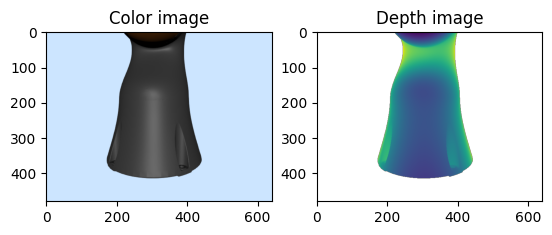

In [13]:
def DepthCameraDemoSystem():
    builder = DiagramBuilder()

    scenario = LoadScenario(data=scenario_string)
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat))

    # Export the camera outputs
    builder.ExportOutput(station.GetOutputPort("camera0.rgb_image"), "rgb_image")
    builder.ExportOutput(station.GetOutputPort("camera0.depth_image"), "depth_image")

    to_point_cloud = AddPointClouds(
        scenario=scenario, station=station, builder=builder, meshcat=meshcat
    )

    # Add a box for the camera in the environment.
    plant = station.GetSubsystemByName("plant")
    camera_instance = plant.GetModelInstanceByName("camera")
    scene_graph = station.GetSubsystemByName("scene_graph")
    AddMultibodyTriad(
        plant.GetFrameByName("base", camera_instance),
        scene_graph,
        length=0.1,
        radius=0.005,
    )

    # Export the point cloud output.
    builder.ExportOutput(
        to_point_cloud["camera0"].point_cloud_output_port(), "point_cloud"
    )

    diagram = builder.Build()
    diagram.set_name("depth_camera_demo_system")
    return diagram


def plot_camera_images():
    system = DepthCameraDemoSystem()

    # Evaluate the camera output ports to get the images.
    context = system.CreateDefaultContext()
    system.ForcedPublish(context)
    color_image = system.GetOutputPort("rgb_image").Eval(context)
    depth_image = system.GetOutputPort("depth_image").Eval(context)

    # Plot the two images.
    plt.subplot(121)
    plt.imshow(color_image.data)
    plt.title("Color image")
    plt.subplot(122)
    plt.imshow(np.squeeze(depth_image.data))
    plt.title("Depth image")
    # mpld3.display()
    plt.show()


plot_camera_images()

In [ ]:
# Spawn in items randomly within the workspace of the robot (I will do this)

In [ ]:
# Compute the velocity of the camera / current position and where it will be expected to be in the future (This is done by them)

In [ ]:
# Add simulator (They need to add the controls information to this)


In [ ]:
# Run Simulator

In [ ]:
# Grader (Unsure if this is necessary)